In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Pytorch package
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Tqdm progress bar
from tqdm import tqdm_notebook, tqdm

from torch.nn import Transformer
from torch.utils.data import TensorDataset, DataLoader

In [25]:
df = pd.read_csv("cgm_data.csv").sample(frac=1)
for column in df.columns:
    df[column] = df[column].astype(float)
df.rename({0:"ID"}, axis=1)
df = df.drop("ptid",axis=1)

In [26]:
df.shape

(97, 480)

In [27]:
df.head()

,0 days 00:00:00,0 days 00:15:00,0 days 00:30:00,0 days 00:45:00,0 days 01:00:00,0 days 01:15:00,0 days 01:30:00,0 days 01:45:00,0 days 02:00:00,0 days 02:15:00,...,4 days 21:30:00,4 days 21:45:00,4 days 22:00:00,4 days 22:15:00,4 days 22:30:00,4 days 22:45:00,4 days 23:00:00,4 days 23:15:00,4 days 23:30:00,4 days 23:45:00
90,181.8,176.4,160.2,147.6,142.2,131.4,122.4,122.4,124.2,122.4,...,124.2,163.8,192.6,192.6,183.6,176.4,160.2,140.4,124.2,113.4
30,248.4,243.0,253.8,268.2,282.6,300.6,313.2,320.4,324.0,324.0,...,246.6,237.6,226.8,214.2,201.6,183.6,165.6,149.4,133.2,122.4
82,70.2,66.6,68.4,79.2,88.2,91.8,95.4,109.8,131.4,158.4,...,208.8,216.0,217.8,207.0,190.8,174.6,158.4,142.2,111.6,82.8
29,149.4,140.4,131.4,126.0,136.8,163.8,185.4,196.2,196.2,192.6,...,99.0,95.4,91.8,86.4,84.6,84.6,84.6,82.8,79.2,75.6
91,194.4,212.4,210.6,180.0,149.4,133.2,122.4,109.8,109.8,124.2,...,192.6,183.6,176.4,169.2,156.6,131.4,115.2,113.4,113.4,100.8


In [28]:
# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are using device: %s" % device)

You are using device: cuda


In [33]:
seq_length = 12
features = 1 # We have one feature, glucose level

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq


# Splitting the data into training and test sets
train_data = df.iloc[1:60].values
test_data = df.iloc[60:97].values

# Creating sequences
train_sequences = create_inout_sequences(train_data, seq_length)
test_sequences = create_inout_sequences(test_data, seq_length)

# If test_sequences is empty, exit the program
if len(test_sequences) == 0:
    print("Not enough data points in the test set to create a sequence of length", seq_length)
    exit()

# Transforming the sequences into tensors
train_input = torch.stack([torch.Tensor(seq[0]) for seq in train_sequences]).float().to(device)
train_target = torch.stack([torch.Tensor(seq[1]) for seq in train_sequences]).float().to(device)

test_input = torch.stack([torch.Tensor(seq[0]) for seq in test_sequences]).float().to(device)
test_target = torch.stack([torch.Tensor(seq[1]) for seq in test_sequences]).float().to(device)

# Reshaping the data to be in the format (Batch Size, Sequence Length, Feature Dimension)
train_input = train_input.view(-1, seq_length, features)
train_target = train_target.view(-1, 1, features) # The target is a single step ahead, so its sequence length is 1
test_input = test_input.view(-1, seq_length, features)
test_target = test_target.view(-1, 1, features) # The target is a single step ahead, so its sequence length is 1

# Creating dataloaders for batching
batch_size = 64
train_dataset = TensorDataset(train_input, train_target)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(test_input, test_target)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)


In [34]:
# Initialize the Transformer model
model = nn.Transformer(
    d_model=features,    # Embedding dimension
    nhead=1,             # Number of heads in multi-head attention
    num_encoder_layers=6, # Number of transformer layers
    batch_first=True).to(device)

# Set the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [35]:
# Training loop
train_losses = []
train_perplexity = []
test_losses = []
test_perplexity = []
for epoch in range(100):  # Number of epochs
    model.train()
    total_loss = 0
    for inputs, targets in train_dataloader:
        inputs = inputs.transpose(0, 1).to(device)
        targets = targets.transpose(0, 1).to(device)

        optimizer.zero_grad()

        # Forward pass
        output = model(inputs, inputs)
        loss = criterion(output[:-1], targets)
        total_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)

    train_losses.append(avg_train_loss)
    train_perplexity.append(np.exp(avg_train_loss))

    # Testing loop within the epoch
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, targets in test_dataloader:
            inputs = inputs.transpose(0, 1).to(device)
            targets = targets.transpose(0, 1).to(device)

            output = model(inputs, inputs)
            loss = criterion(output[:-1], targets)
            total_loss += loss.item()

    avg_test_loss = total_loss / len(test_dataloader)
    test_losses.append(avg_test_loss)
    test_perplexity.append(np.exp(avg_test_loss))

    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Training Loss: {avg_train_loss}, Testing Loss: {avg_test_loss}')

Epoch: 0, Training Loss: 25392.349227602692, Testing Loss: 20652.58025863323
Epoch: 10, Training Loss: 24362.080393502125, Testing Loss: 19724.465568380154
Epoch: 20, Training Loss: 23349.528356276558, Testing Loss: 18823.06756851521
Epoch: 30, Training Loss: 22356.23976960871, Testing Loss: 17946.552307128906
Epoch: 40, Training Loss: 21390.08087486721, Testing Loss: 17094.731662182097
Epoch: 50, Training Loss: 20451.09056579763, Testing Loss: 16267.673093755195
Epoch: 60, Training Loss: 19539.054045679888, Testing Loss: 15465.32200525162
Epoch: 70, Training Loss: 18644.15245440864, Testing Loss: 14687.669976417055
Epoch: 80, Training Loss: 17778.75149112518, Testing Loss: 13934.67563320728
Epoch: 90, Training Loss: 16941.998879581268, Testing Loss: 13206.369874994805


In [36]:
torch.save(model, "simple_transformer")

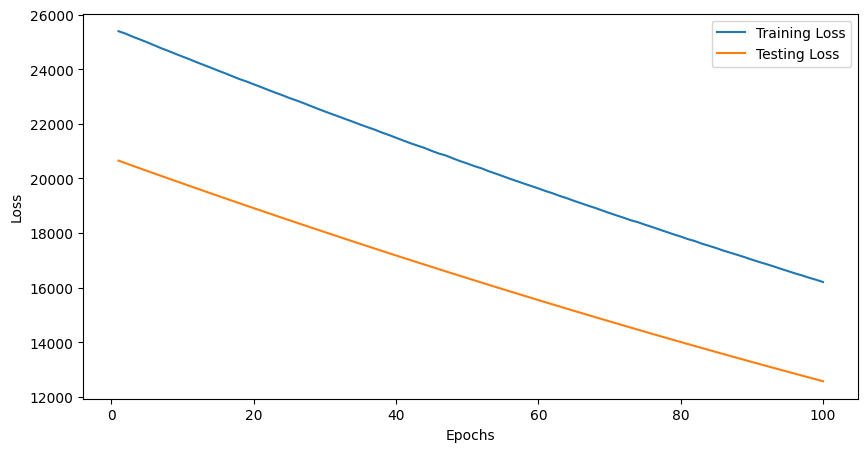

In [37]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, epochs+1), train_losses, label='Training Loss')
plt.plot(np.arange(1, epochs+1), test_losses, label='Testing Loss')
plt.title('Simple Transformer Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'simple_transformer_learning_curve_final.png')
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, epochs+1), train_perplexity, label='Training Perplexity')
plt.plot(np.arange(1, epochs+1), test_perplexity, label='Test Perplexity')
plt.title('Simple Transformer Perplexity Curve')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.legend()
plt.savefig(f'simple_transformer_perplexity_curve_final.png')
plt.show()